In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pickle

In [14]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./train_adj_matrix_{NUMBER_NODES}',
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./test_adj_matrix_{NUMBER_NODES}/test_images',
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    return train_ds, val_ds

In [15]:
train_ds, val_ds = load_data()

Found 981 files belonging to 464 classes.
Found 63 files belonging to 55 classes.


In [16]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(NUMBER_NODES, NUMBER_NODES, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save test_Data to use it in compareResults (output_band, optimal_band, reverse-cuthill-mckee_band)
# with open(os.path.join(os.path.abspath(''), 'class_names_adj_matrix.pickle'), 'wb') as f:
    # pickle.dump(class_names, f, pickle.HIGHEST_PROTOCOL)

In [17]:
model = models.Sequential()
# model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(NUMBER_NODES, NUMBER_NODES, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=128,
)

Epoch 1/128
31/31 [==============================] - 2s 54ms/step - loss: 6.0110 - accuracy: 0.0795 - val_loss: 6.3789 - val_accuracy: 0.0000e+00
Epoch 2/128
31/31 [==============================] - 2s 52ms/step - loss: 5.6554 - accuracy: 0.0999 - val_loss: 6.4005 - val_accuracy: 0.0000e+00
Epoch 3/128
31/31 [==============================] - 2s 52ms/step - loss: 5.3976 - accuracy: 0.1111 - val_loss: 6.7304 - val_accuracy: 0.0000e+00
Epoch 4/128
31/31 [==============================] - 2s 48ms/step - loss: 5.0621 - accuracy: 0.1213 - val_loss: 7.0039 - val_accuracy: 0.0000e+00
Epoch 5/128
31/31 [==============================] - 2s 50ms/step - loss: 4.6563 - accuracy: 0.1458 - val_loss: 7.2902 - val_accuracy: 0.0000e+00
Epoch 6/128
31/31 [==============================] - 2s 58ms/step - loss: 4.1940 - accuracy: 0.1764 - val_loss: 8.0620 - val_accuracy: 0.0000e+00
Epoch 7/128
31/31 [==============================] - 2s 54ms/step - loss: 3.7110 - accuracy: 0.2039 - val_loss: 9.0580 - val

In [18]:
model.save('adj_matrix_classification_model')

INFO:tensorflow:Assets written to: CNN_dir_adj2_model-COPY\assets


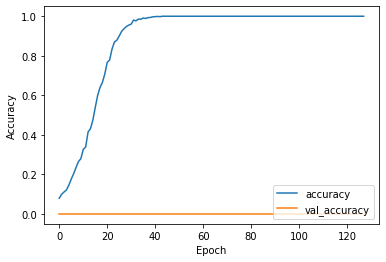

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

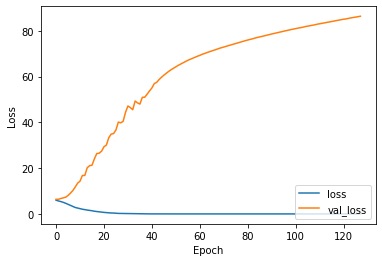

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [21]:
def get_bandwidth(Graph, nodelist=None):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    if nodelist.all() != None:
        L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    else:
        L = nx.laplacian_matrix(Graph)
    x, y = np.nonzero(L)
    return (x-y).max()
    
def count_repeats(output):
    counts = np.unique(np.round(output))
    repeated = NUMBER_NODES - counts.shape[0]
    return repeated

def get_valid_pred(pred):
    valid = np.ones(7)
    labels = np.arange(0, 7)
    for i in labels:
        min_value = np.amin(pred)
        min_idx = np.where(pred == min_value)
        pred[min_idx] = 100
        valid[min_idx] = i
    return valid

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    # data /= 255.0
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((32, 32), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def get_np_rray(strArray):
    arr = list(strArray)
    arr = list(map(int, arr))
    return np.array(arr)

def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_adj_matrix_{NUMBER_NODES}/test_{NUMBER_NODES}.csv')
    print(df.shape)

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber + 1 : ].values # skip bandwidth value
    return features, labels

def get_images_from_uppertriangle(x):
    data = []
    for i in x:
        image_np = processDataToAdjImage(i)
        data.append(image_np)
    return np.array(data)

In [22]:
x_test, y_test = load_test_data()
print(x_test.shape)
print(y_test.shape)

(63, 29)
(63, 21)
(63, 7)


In [23]:
x_test, y_test = load_test_data()

x_images_test = get_images_from_uppertriangle(x_test)
pred = model.predict(x_images_test)

sumTest_original = 0
sumTest_pred = 0
sumTest_true = 0

count = 0
cases_with_repetition = 0

for i in range(len(pred)):
    str_pred_nodelist = class_names[np.argmax(pred[i])]
    str_true_nodelist = y_test[i]

    output = get_np_rray(str_pred_nodelist)
    true = get_np_rray(str_true_nodelist)

    quantity_repeated = count_repeats(np.round(output))
    print('Pred: ', output)
    print('True: ', true)
    if quantity_repeated != 0:
        cases_with_repetition += 1
    output = get_valid_pred(output)
    print('Pred valid: ', output)
    count += quantity_repeated

    print("Bandwidth")
    graph = getGraph(x_test[i])
    original_band = get_bandwidth(graph, np.array(None))
    sumTest_original += original_band
    pred_band = get_bandwidth(graph, output)
    sumTest_pred += pred_band
    true_band = get_bandwidth(graph, true)
    sumTest_true += true_band
    print("Bandwidth")
    print(original_band)
    print(pred_band)
    print(true_band)
print('Quantidade de rótulos repetidos, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 6 - ', count)
print('Quantidade de saídas com repetição, exemplo [1, 1, 1, 1, 1, 1, 1] conta como 1 - ', cases_with_repetition)
test_length = pred.shape[0]
print('Test length - ', test_length)
print("Bandwidth mean")
print(sumTest_original / test_length)
print("Pred bandwidth mean")
print(sumTest_pred / test_length)
print("True bandwidth mean")
print(sumTest_true / test_length)

(63, 29)
Pred:  [1 5 6 0 3 2 4]
True:  [1 5 6 0 3 2 4]
Pred valid:  [1. 5. 6. 0. 3. 2. 4.]
Bandwidth
Bandwidth
6
2
2
Pred:  [1 0 5 4 6 2 3]
True:  [3 0 6 4 5 2 1]
Pred valid:  [1. 0. 5. 4. 6. 2. 3.]
Bandwidth
Bandwidth
6
3
3
Pred:  [1 5 3 4 0 6 2]
True:  [1 5 6 0 2 4 3]
Pred valid:  [1. 5. 3. 4. 0. 6. 2.]
Bandwidth
Bandwidth
6
5
2
Pred:  [3 6 4 0 2 5 1]
True:  [2 0 4 6 5 1 3]
Pred valid:  [3. 6. 4. 0. 2. 5. 1.]
Bandwidth
Bandwidth
6
5
2
Pred:  [3 1 2 6 5 0 4]
True:  [1 2 6 4 0 5 3]
Pred valid:  [3. 1. 2. 6. 5. 0. 4.]
Bandwidth
Bandwidth
6
3
2
Pred:  [4 3 1 6 5 0 2]
True:  [4 0 2 6 5 3 1]
Pred valid:  [4. 3. 1. 6. 5. 0. 2.]
Bandwidth
Bandwidth
6
5
3
Pred:  [2 1 5 4 6 0 3]
True:  [2 3 1 4 5 6 0]
Pred valid:  [2. 1. 5. 4. 6. 0. 3.]
Bandwidth
Bandwidth
6
3
3
Pred:  [1 4 6 0 2 5 3]
True:  [1 4 6 0 2 5 3]
Pred valid:  [1. 4. 6. 0. 2. 5. 3.]
Bandwidth
Bandwidth
6
2
2
Pred:  [3 2 5 6 1 0 4]
True:  [3 5 2 6 0 1 4]
Pred valid:  [3. 2. 5. 6. 1. 0. 4.]
Bandwidth
Bandwidth
5
3
3
Pred:  [1 4 6 0 5 2